In [1]:
import os
import json
import pyqg_subgrid_experiments as pse
import argparse
import time
import torch
import matplotlib.pyplot as plt
from pyqg_subgrid_experiments.models import ProbabilisticCNN
%load_ext autoreload
%autoreload 2

In [2]:
torch.cuda.is_available()

False

In [3]:
parser = argparse.ArgumentParser()
parser.add_argument('--train_set', type=str, default="/scratch/zanna/data/pyqg/data/train/0.nc")
parser.add_argument('--test_set', type=str, default="/scratch/zanna/data/pyqg/data/test/*.nc")
parser.add_argument('--transfer_set', type=str, default="/scratch/zanna/data/pyqg/data/transfer/*.nc")
parser.add_argument('--save_dir', type=str, default="PCNN_var_0_0001_epoch_var_25")
parser.add_argument('--inputs', type=str, default="u,v,q")
parser.add_argument('--targets', type=str, default="q_forcing_advection")
parser.add_argument('--zero_mean', type=int, default=1)
parser.add_argument('--num_epochs', type=int, default=50)
parser.add_argument('--layerwise_inputs', type=int, default=0)
parser.add_argument('--layerwise_targets', type=int, default=0)

_StoreAction(option_strings=['--layerwise_targets'], dest='layerwise_targets', nargs=None, const=None, default=0, type=<class 'int'>, choices=None, help=None, metavar=None)

In [4]:
args = parser.parse_args("")

In [5]:
save_dir = args.save_dir
test_dir = os.path.join(save_dir, "test")
xfer_dir = os.path.join(save_dir, "transfer")
for d in [save_dir, test_dir, xfer_dir]:
    os.system(f"mkdir -p {d}") 

with open(f"{save_dir}/model_config.json", 'w') as f:
    f.write(json.dumps(args.__dict__))

In [6]:
train = pse.Dataset(args.train_set)
test = pse.Dataset(args.test_set)
xfer = pse.Dataset(args.transfer_set)

In [7]:
param = pse.CNNParameterization.train_on(train, save_dir,
            inputs=args.inputs.split(","),
            targets=args.targets.split(","),
            layerwise_inputs=False,
            layerwise_targets=True,
            zero_mean=args.zero_mean,
            model_class=ProbabilisticCNN,
            num_epochs=50,
            channel_type = 'var')

channel_type: var
self.channel_type: var
self.channel_type: var
self.channel_type: var
self.channel_type: var
model 0: var
model 1: var


In [8]:
test_result = param.test_offline(test, os.path.join(test_dir, "offline_metrics.nc"))

In [9]:
transfer_result = param.test_offline(xfer, os.path.join(xfer_dir, "offline_metrics.nc"))

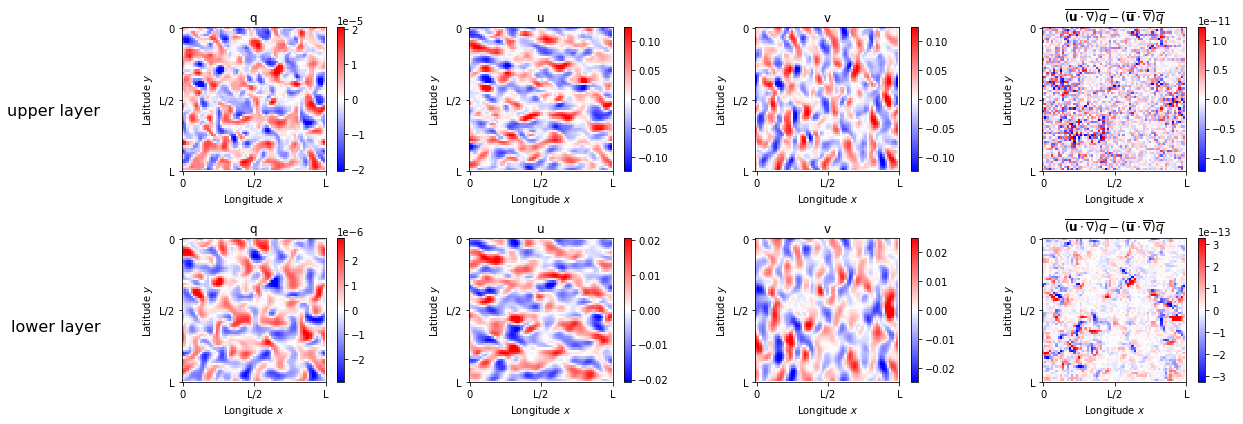

In [32]:
ds = train.isel(run=0,time=-1)
with pse.figure_grid(2,4) as g:
    g.fig.text(0, 0.75, 'upper layer', ha='right', va='top', fontsize=16)
    g.fig.text(0, 0.25, 'lower layer', ha='right', va='top', fontsize=16)
    g.next(); pse.imshow(ds.q.isel(lev=0), title='q')
    g.next(); pse.imshow(ds.u.isel(lev=0), title='u')
    g.next(); pse.imshow(ds.v.isel(lev=0), title='v')
    g.next(); pse.imshow(ds.q_forcing_advection.isel(lev=0), title=r'$\overline{(\mathbf{u} \cdot \nabla)q} - (\overline{\mathbf{u}} \cdot \overline{\nabla})\overline{q}$')
    
    g.next(); pse.imshow(ds.q.isel(lev=1), title='q')
    g.next(); pse.imshow(ds.u.isel(lev=1), title='u')
    g.next(); pse.imshow(ds.v.isel(lev=1), title='v')
    g.next(); pse.imshow(ds.q_forcing_advection.isel(lev=1), title=r'$\overline{(\mathbf{u} \cdot \nabla)q} - (\overline{\mathbf{u}} \cdot \overline{\nabla})\overline{q}$')
    

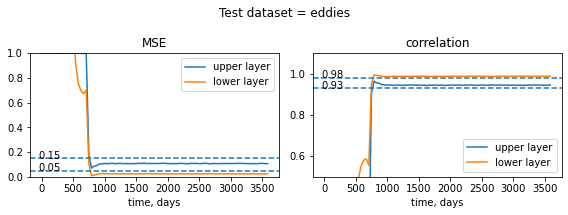

In [10]:
import numpy as np
ds = test_result
with pse.figure_grid(1,2) as g:
    g.title('Test dataset = eddies')
    time = ds.coords['time']
    if time.dtype == np.dtype('<m8[ns]'):
        time = (time.data / np.timedelta64(1, 'D')).astype(int)
    g.next(title="MSE")
    plt.plot(time,1-ds.q_forcing_advection_temporal_skill)
    plt.ylim([0,1])
    plt.legend(['upper layer', 'lower layer'])
    plt.xlabel('time, days')
    plt.axhline(y=0.05,linestyle='--')
    plt.text(x=-50,y=0.05,s='0.05')
    plt.axhline(y=0.15,linestyle='--')
    plt.text(x=-50,y=0.15,s='0.15')
    
    g.next(title="correlation")
    plt.plot(time,ds.q_forcing_advection_temporal_correlation)
    plt.ylim([0.5,1.1])
    plt.legend(['upper layer', 'lower layer'])
    plt.xlabel('time, days')
    plt.axhline(y=0.93,linestyle='--')
    plt.text(x=-50,y=0.93,s='0.93')
    plt.axhline(y=0.98,linestyle='--')
    plt.text(x=-50,y=0.98,s='0.98')

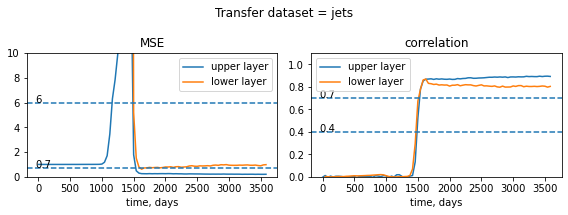

In [11]:
import numpy as np
ds = transfer_result
with pse.figure_grid(1,2) as g:
    g.title('Transfer dataset = jets')
    time = ds.coords['time']
    if time.dtype == np.dtype('<m8[ns]'):
        time = (time.data / np.timedelta64(1, 'D')).astype(int)
    g.next(title="MSE")
    plt.plot(time,1-ds.q_forcing_advection_temporal_skill)
    plt.ylim([0,10])
    plt.legend(['upper layer', 'lower layer'])
    plt.xlabel('time, days')
    plt.axhline(y=0.7,linestyle='--')
    plt.text(x=-50,y=0.7,s='0.7')
    plt.axhline(y=6,linestyle='--')
    plt.text(x=-50,y=6,s='6')
    
    g.next(title="correlation")
    plt.plot(time,ds.q_forcing_advection_temporal_correlation)
    plt.ylim([0.0,1.1])
    plt.legend(['upper layer', 'lower layer'])
    plt.xlabel('time, days')
    plt.axhline(y=0.4,linestyle='--')
    plt.text(x=-50,y=0.4,s='0.4')
    plt.axhline(y=0.7,linestyle='--')
    plt.text(x=-50,y=0.7,s='0.7')

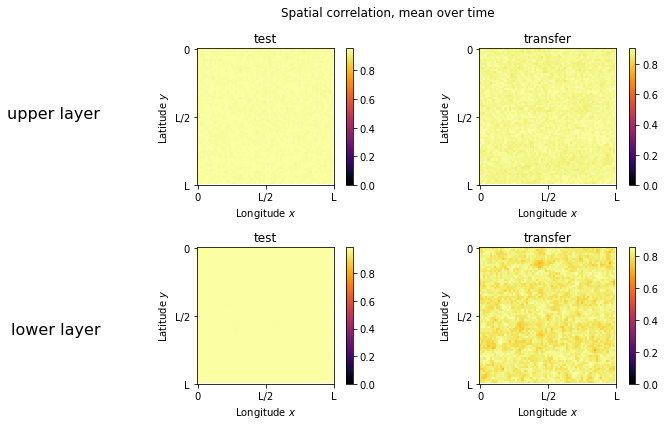

In [12]:
te = test_result
tr = transfer_result
with pse.figure_grid(2,2) as g:
    g.title('Spatial correlation, mean over time')
    g.fig.text(0, 0.75, 'upper layer', ha='right', va='top', fontsize=16)
    g.fig.text(0, 0.25, 'lower layer', ha='right', va='top', fontsize=16)
    g.next(); pse.imshow(te.q_forcing_advection_spatial_correlation.isel(lev=0), title='test')
    g.next(); pse.imshow(tr.q_forcing_advection_spatial_correlation.isel(lev=0), title='transfer')
    
    g.next(); pse.imshow(te.q_forcing_advection_spatial_correlation.isel(lev=1), title='test')
    g.next(); pse.imshow(tr.q_forcing_advection_spatial_correlation.isel(lev=1), title='transfer')
    

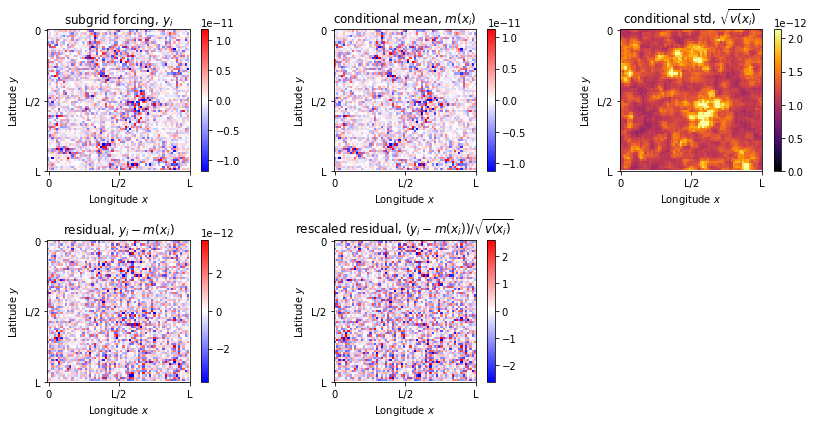

In [31]:
tt = test_result.isel(run=0,time=-1)
with pse.figure_grid(2,3) as g:
    g.next(); pse.imshow(tt.q_forcing_advection.isel(lev=0), title='subgrid forcing, $y_i$')
    g.next(); pse.imshow(tt.q_forcing_advection_predictions.isel(lev=0), title='conditional mean, $m(x_i)$')
    std = np.sqrt(tt.q_forcing_advection_var_predictions.isel(lev=0))
    residual = tt.q_forcing_advection.isel(lev=0) - tt.q_forcing_advection_predictions.isel(lev=0)
    g.next(); pse.imshow(std, title='conditional std, $\sqrt{v(x_i)}$')
    g.next(); pse.imshow(residual, title='residual, $y_i-m(x_i)$')
    g.next(); pse.imshow(residual/std, title='rescaled residual, $(y_i-m(x_i))/\sqrt{v(x_i)}$')